# Convolutional Neural Networks (CNNs)

## What are CNNs?

Convolutional Neural Networks (CNNs) are a class of deep neural networks that are particularly effective for image recognition and computer vision tasks. They are inspired by the visual cortex of animals and use a mathematical operation called convolution to process data that has a grid-like topology, such as images.

### Key Concepts:

1. **Convolution**: A mathematical operation that slides a small filter (kernel) across the input to extract features
2. **Pooling**: Reduces the spatial dimensions of the feature maps to decrease computational load
3. **Feature Maps**: The output of applying filters to the input, highlighting specific features
4. **Hierarchical Learning**: Lower layers learn simple features (edges, corners), higher layers learn complex patterns

In this tutorial, we'll build a CNN for image classification using the CIFAR-10 dataset.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and Preprocessing the CIFAR-10 Dataset

CIFAR-10 is a dataset of 60,000 32x32 color images in 10 classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and load the datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

# Create data loaders
batch_size = 128
# Set num_workers=0 for compatibility across platforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(classes)}')

Training samples: 50000
Test samples: 10000
Number of classes: 10


## Visualizing Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


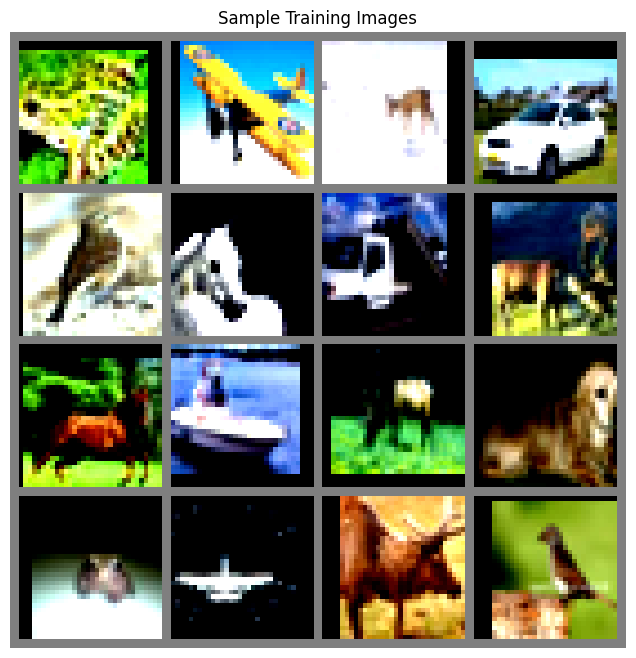

Labels: frog  plane deer  car   bird  horse truck deer  horse ship  deer  dog   frog  plane deer  bird 


In [3]:
def imshow(img, title=None):
    """Display image with optional title"""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4),
       title='Sample Training Images')

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

## Building the CNN Model

Our CNN architecture will consist of:
1. Convolutional layers to extract features
2. Batch normalization for stable training
3. ReLU activation functions
4. Max pooling to reduce spatial dimensions
5. Fully connected layers for classification

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        # First block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # Second block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Third block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Create model instance
model = CNN(num_classes=10).to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

# Print model architecture
print("\nModel Architecture:")
print(model)

Model parameters: 1,343,146

Model Architecture:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d

## Visualizing Feature Maps

Let's visualize what the CNN sees at different layers

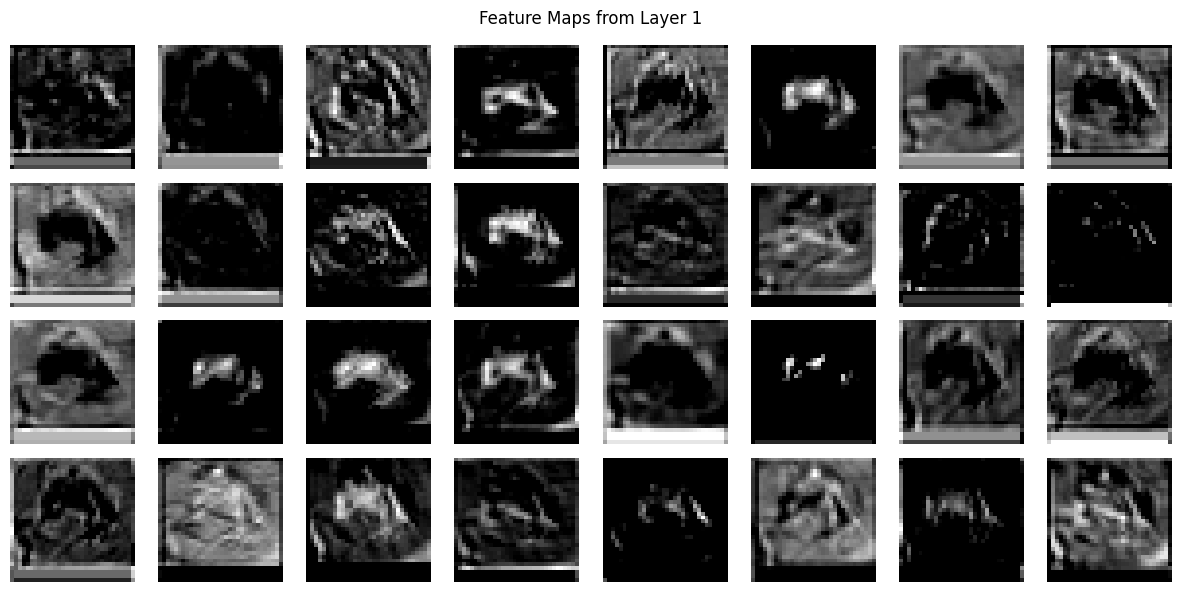

In [5]:
def visualize_feature_maps(model, image, layer_num=1):
    """Visualize feature maps from a specific layer"""
    model.eval()
    
    # Forward pass through first few layers
    x = image.unsqueeze(0).to(device)
    
    if layer_num == 1:
        x = F.relu(model.bn1(model.conv1(x)))
    elif layer_num == 2:
        x = F.relu(model.bn1(model.conv1(x)))
        x = F.relu(model.bn2(model.conv2(x)))
    elif layer_num == 3:
        x = F.relu(model.bn1(model.conv1(x)))
        x = F.relu(model.bn2(model.conv2(x)))
        x = model.pool1(x)
        x = F.relu(model.bn3(model.conv3(x)))
    
    # Convert to numpy
    feature_maps = x.squeeze(0).cpu().detach().numpy()
    
    # Plot feature maps
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[0]:
            ax.imshow(feature_maps[i], cmap='gray')
        ax.axis('off')
    
    plt.suptitle(f'Feature Maps from Layer {layer_num}')
    plt.tight_layout()
    plt.show()

# Visualize feature maps for a sample image
sample_image, _ = train_dataset[0]
visualize_feature_maps(model, sample_image, layer_num=1)

## Training the CNN

We'll train our CNN using:
- Cross-entropy loss for multi-class classification
- Adam optimizer with learning rate scheduling
- Data augmentation (already applied in transforms)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [7]:
# Training loop
num_epochs = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print(f'Saved best model with validation accuracy: {val_acc:.2f}%')

Starting training...

Epoch 1/5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.95it/s]


Train Loss: 1.6767, Train Acc: 38.37%
Val Loss: 1.1974, Val Acc: 56.11%
Learning Rate: 0.001000
Saved best model with validation accuracy: 56.11%

Epoch 2/5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.77it/s]


Train Loss: 1.3022, Train Acc: 52.93%
Val Loss: 0.9832, Val Acc: 64.77%
Learning Rate: 0.001000
Saved best model with validation accuracy: 64.77%

Epoch 3/5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 17.48it/s]


Train Loss: 1.1221, Train Acc: 59.85%
Val Loss: 0.8478, Val Acc: 70.37%
Learning Rate: 0.001000
Saved best model with validation accuracy: 70.37%

Epoch 4/5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.00it/s]


Train Loss: 1.0208, Train Acc: 63.87%
Val Loss: 0.7777, Val Acc: 72.30%
Learning Rate: 0.001000
Saved best model with validation accuracy: 72.30%

Epoch 5/5


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:04<00:00, 18.54it/s]

Train Loss: 0.9393, Train Acc: 66.81%
Val Loss: 0.7476, Val Acc: 74.11%
Learning Rate: 0.001000
Saved best model with validation accuracy: 74.11%


## Visualizing Training Progress

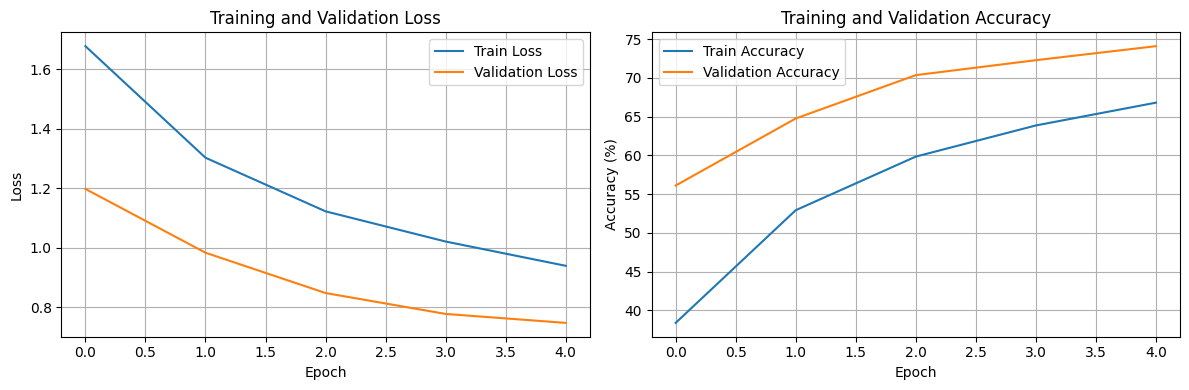

Best validation accuracy: 74.11%


In [8]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f'Best validation accuracy: {best_val_acc:.2f}%')

## Evaluating Model Performance

Let's analyze our model's performance in detail

In [9]:
# Load best model
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()

# Compute per-class accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print per-class accuracy
print("Per-class Accuracy:")
print("-" * 30)
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'{classes[i]:10s}: {accuracy:.2f}%')

# Overall accuracy
overall_accuracy = 100 * sum(class_correct) / sum(class_total)
print("-" * 30)
print(f'Overall Accuracy: {overall_accuracy:.2f}%')

Per-class Accuracy:
------------------------------
plane     : 73.00%
car       : 84.00%
bird      : 47.80%
cat       : 50.40%
deer      : 73.80%
dog       : 68.30%
frog      : 84.50%
horse     : 82.00%
ship      : 83.20%
truck     : 94.10%
------------------------------
Overall Accuracy: 74.11%


## Visualizing Model Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

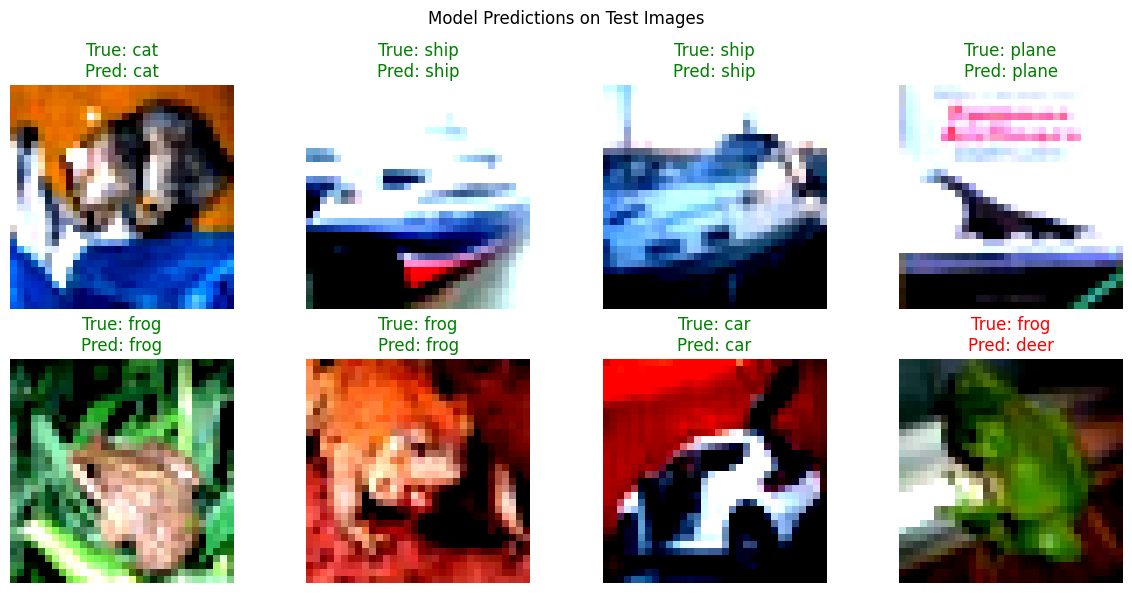

In [10]:
def show_predictions(model, loader, num_images=8):
    """Show model predictions on random test images"""
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:num_images].to(device), labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
    # Move to CPU for plotting
    images = images.cpu()
    predicted = predicted.cpu()
    
    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            # Unnormalize image
            img = images[idx] / 2 + 0.5
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            
            true_label = classes[labels[idx]]
            pred_label = classes[predicted[idx]]
            
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
        ax.axis('off')
    
    plt.suptitle('Model Predictions on Test Images')
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)

## Confusion Matrix

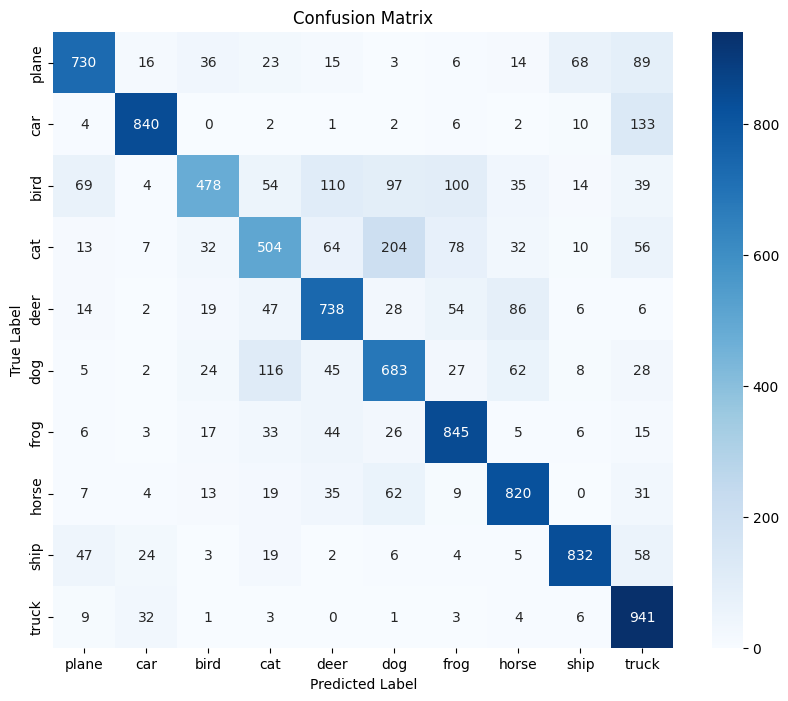

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Understanding CNN Filters

Let's visualize the learned filters in the first convolutional layer

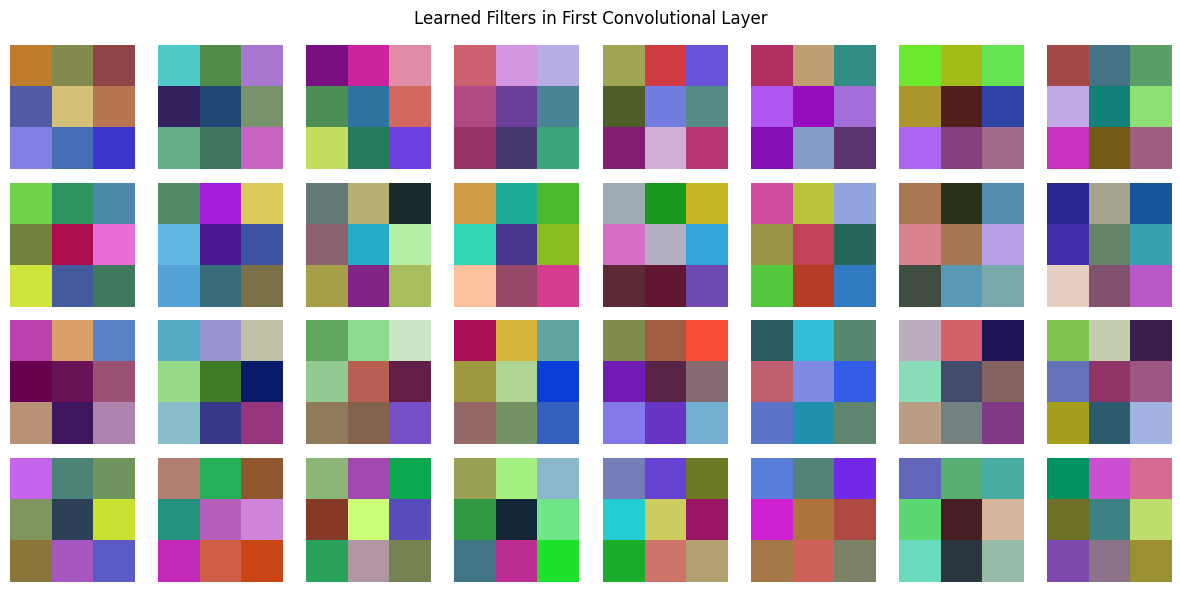

In [12]:
def visualize_filters(model, layer_name='conv1'):
    """Visualize convolutional filters"""
    # Get the weights of the first conv layer
    weights = model.conv1.weight.data.cpu()
    
    # Normalize weights for visualization
    min_val = weights.min()
    max_val = weights.max()
    weights = (weights - min_val) / (max_val - min_val)
    
    # Plot filters
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            # Get the filter
            filter_img = weights[i].permute(1, 2, 0)
            ax.imshow(filter_img)
        ax.axis('off')
    
    plt.suptitle('Learned Filters in First Convolutional Layer')
    plt.tight_layout()
    plt.show()

visualize_filters(model)

## Exercises

Now it's your turn to experiment with CNNs! Try these exercises:

### Exercise 1: Modify the Architecture
Try modifying the CNN architecture:
- Add or remove convolutional layers
- Change the number of filters
- Experiment with different kernel sizes (3x3, 5x5, 7x7)
- Try different pooling strategies (average pooling vs max pooling)

In [13]:
# Exercise 1: Create your modified CNN here
class ModifiedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedCNN, self).__init__()
        # TODO: Implement your modified architecture
        pass
    
    def forward(self, x):
        # TODO: Implement the forward pass
        pass

# Train and evaluate your model
# modified_model = ModifiedCNN().to(device)

### Exercise 2: Data Augmentation
Experiment with different data augmentation techniques:
- Add rotation
- Try color jittering
- Implement cutout or mixup augmentation

In [14]:
# Exercise 2: Define new data augmentation transforms
new_transform = transforms.Compose([
    # TODO: Add your augmentation techniques here
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create new dataset with your transforms
# augmented_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                                  transform=new_transform)

### Exercise 3: Transfer Learning
Use a pre-trained model (like ResNet) and fine-tune it on CIFAR-10

In [15]:
# Exercise 3: Implement transfer learning
# from torchvision.models import resnet18

# def create_transfer_model(num_classes=10):
#     # TODO: Load pre-trained model
#     # TODO: Modify the final layer for CIFAR-10
#     # TODO: Freeze early layers (optional)
#     pass

# transfer_model = create_transfer_model()

### Exercise 4: Implement Grad-CAM
Implement Gradient-weighted Class Activation Mapping to visualize which parts of the image the CNN focuses on

In [16]:
# Exercise 4: Implement Grad-CAM
def grad_cam(model, image, target_layer, class_idx=None):
    """
    Implement Grad-CAM visualization
    
    Args:
        model: The CNN model
        image: Input image tensor
        target_layer: The layer to visualize
        class_idx: Target class index (if None, use predicted class)
    
    Returns:
        heatmap: The Grad-CAM heatmap
    """
    # TODO: Implement Grad-CAM
    pass

# Use Grad-CAM on a test image
# test_image, test_label = test_dataset[0]
# heatmap = grad_cam(model, test_image, model.conv6)

## Summary

In this tutorial, we've covered:

1. **CNN Architecture**: Convolutional layers, pooling, and fully connected layers
2. **Training Process**: Loss functions, optimizers, and learning rate scheduling
3. **Data Augmentation**: Techniques to improve generalization
4. **Visualization**: Feature maps, filters, and model predictions
5. **Evaluation**: Per-class accuracy and confusion matrices

CNNs are powerful tools for computer vision tasks. Key takeaways:
- Convolutional layers learn hierarchical features
- Pooling reduces spatial dimensions and provides translation invariance
- Data augmentation is crucial for good generalization
- Batch normalization and dropout help with training stability

Continue experimenting with different architectures and techniques to deepen your understanding!